# LeNet on CIFAR-10 with TensorFlow Keras

This notebook shows how to recreate the LeNet classifier using **TensorFlow Keras**, and how to train it on the **CIFAR-10** dataset.

You will learn:

- What LeNet is and why it mattered
- How convolution, pooling, and fully-connected layers work
- How to prepare image data for a neural network
- How to choose loss functions, optimizers, and metrics
- How to train and evaluate a model in Keras

**Audience:** Readers with little or no modern AI/ML background. We explain each concept as we use it.


## 1. What is LeNet?

**LeNet-5** (1998) is one of the earliest successful convolutional neural networks (CNNs). It was designed for recognizing handwritten digits (like those in the MNIST dataset). LeNet introduced the idea of:

- Alternating **convolution** and **pooling** layers
- A small **fully-connected** classifier head

LeNet is much smaller than modern CNNs, which makes it a great **learning model**. We will adapt it to **CIFAR-10** (color images, 10 classes).


## 2. Setup

We will use **TensorFlow Keras**, which provides high-level building blocks for neural networks. If you are running locally and need to install TensorFlow:

```bash
pip install tensorflow
```

or

```bash
uv add tensorflow
```

We also set a random seed so results are easier to reproduce.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


## 3. Load CIFAR-10

Keras can download CIFAR-10 for us. The data comes as **NumPy arrays**:

- `x_train`: training images
- `y_train`: training labels (0-9)
- `x_test`, `y_test`: test set

Each image has shape **32x32x3** (height, width, color channels).


/Users/pmui/SynologyDrive/research/2026/research2026/01-nn/.venv/lib/python3.12/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


Train images: (50000, 32, 32, 3)
Train labels: (50000, 1)
Test images: (10000, 32, 32, 3)
Test labels: (10000, 1)


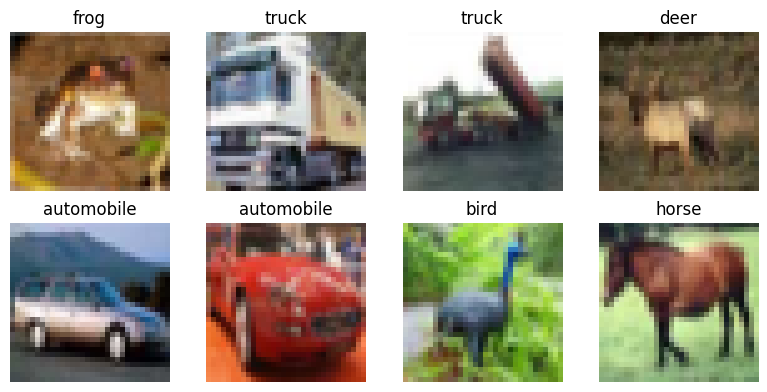

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

print("Train images:", x_train.shape)
print("Train labels:", y_train.shape)
print("Test images:", x_test.shape)
print("Test labels:", y_test.shape)

# Show a few sample images
plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis("off")
plt.tight_layout()
plt.show()

## 4. Preprocess the data

Neural networks learn best when inputs are scaled to small ranges.

We will:

1. **Normalize** pixel values from 0-255 to 0-1.
2. Keep the **original 32x32 size**, because LeNet was designed for small images.
3. Build **tf.data pipelines** for efficient loading, shuffling, and batching.
4. Apply **data augmentation** (small random flips and shifts) to reduce overfitting.

**Why no resizing?** LeNet was designed for small inputs (originally 32x32). CIFAR-10 already matches that size.


In [3]:
BATCH_SIZE = 64

# Data augmentation only for training
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# Preprocessing: normalize only
preprocess = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1.0 / 255),
])

def prepare_dataset(images, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if training:
        ds = ds.shuffle(5000, seed=SEED)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.map(lambda x, y: (preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (augment(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = prepare_dataset(x_train, y_train, training=True)
test_ds = prepare_dataset(x_test, y_test, training=False)

## 5. LeNet architecture (concepts)

LeNet follows a simple pattern: **conv -> pool -> conv -> pool -> dense**.

### Convolution layers

- Learn small patterns like edges and textures.
- **Kernel size** (e.g., 5x5) controls how wide each filter sees.

### Pooling layers

- **Average pooling** was used in the original LeNet to smooth features.
- **Max pooling** is more common today because it keeps the strongest features.

We will use **average pooling** to stay closer to the original LeNet.

### Fully-connected layers

After the convolutions, we flatten the features and classify with dense layers.

### Activation functions

- We will use **ReLU** instead of the original **tanh**, because ReLU trains faster and is a modern standard.

**Why change some details?** Modern tweaks (like ReLU) usually improve training stability while keeping the classic structure.

### Number of nodes:

- Input: Number of nodes: 32 \cdot 32 \cdot 3 = 3072
- Conv: 6 filters: 28 \cdot 28 \cdot 6 = 4704
- AvgPool: 14 \cdot 14 \cdot 6 = 1176 nodes


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),  # 32x32x3 = 3072 nodes

    # Conv block 1
    layers.Conv2D(6, kernel_size=5, activation="relu", padding="valid"),
    layers.AveragePooling2D(pool_size=2, strides=2),

    # Conv block 2
    layers.Conv2D(16, kernel_size=5, activation="relu", padding="valid"),
    layers.AveragePooling2D(pool_size=2, strides=2),

    # Classifier head
    layers.Flatten(),
    layers.Dense(120, activation="relu"),
    layers.Dense(84, activation="relu"),
    layers.Dense(10, activation="softmax"),
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,006 (242.21 KB)

 Trainable params: 62,006 (242.21 KB)

 Non-trainable params: 0 (0.00 B)

**Note on differences vs the original LeNet-5**

- LeNet-5 used **tanh** activations and **average pooling**. We keep average pooling but switch to **ReLU** for simpler training.
- LeNet-5 was designed for **grayscale 32x32** images. CIFAR-10 is **color 32x32**, so we use 3 input channels.


## 6. Loss function, optimizer, and metrics

### Loss (what we optimize)

We are doing **multi-class classification** (10 classes). Each image belongs to exactly one class.

We will use **Sparse Categorical Crossentropy**:

- "Categorical" means multi-class
- "Sparse" means labels are integers (0-9) instead of one-hot vectors

**Common alternatives:**

- `CategoricalCrossentropy` if your labels are one-hot encoded
- `BinaryCrossentropy` for two classes or multi-label tasks

### Optimizer (how we update weights)

We will use **Adam**, a popular optimizer that adapts the learning rate for each parameter.

**Common alternatives:**

- **SGD** (Stochastic Gradient Descent): simpler and sometimes more stable
- **RMSprop**: good for noisy gradients
- **Adagrad**: adapts learning rates but can slow too much later

### Metrics (how we measure progress)

We will use **accuracy**. It reports the percentage of correct predictions.

**Common alternatives:**

- **Top-K accuracy** (correct if the true class is in the top K predictions)
- **Precision/Recall/F1** (useful for imbalanced data)


In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

## 7. Train the model

Training means showing the network images and labels, then adjusting weights to reduce the loss.

Key parameters:

- **Epochs**: how many times we pass through the full training set
- **Batch size**: number of images per training step (set in the dataset pipeline)
- **Learning rate**: how big each weight update is

We will train for a small number of epochs to keep this tutorial fast. You can increase it later.


In [ ]:
%%time

if os.path.exists("models/lenet_cifar10.weights.h5"):
    model.load_weights("models/lenet_cifar10.weights.h5")
else:
    EPOCHS = 50

    history = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=EPOCHS,
    )
    model.save("models/lenet_cifar10.keras")
    model.save_weights("models/lenet_cifar10.weights.h5")

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6595 - loss: 0.9523 - val_accuracy: 0.6596 - val_loss: 0.9597
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6618 - loss: 0.9499 - val_accuracy: 0.6786 - val_loss: 0.9203
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6626 - loss: 0.9520 - val_accuracy: 0.6561 - val_loss: 0.9819
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6641 - loss: 0.9426 - val_accuracy: 0.6661 - val_loss: 0.9531
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6686 - loss: 0.9373 - val_accuracy: 0.6742 - val_loss: 0.9250
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6680 - loss: 0.9391 - val_accuracy: 0.6696 - val_loss: 0.9438
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6679 - loss: 0.9391 - val_accuracy: 0.6717 - val_loss: 0.9307
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6729 - loss: 0.9240 - val_accu

## 8. Evaluate and visualize results

We can evaluate accuracy on the test set and plot the training curves. We will also build a simple confusion matrix to see which classes are commonly confused.


Test accuracy: 0.695


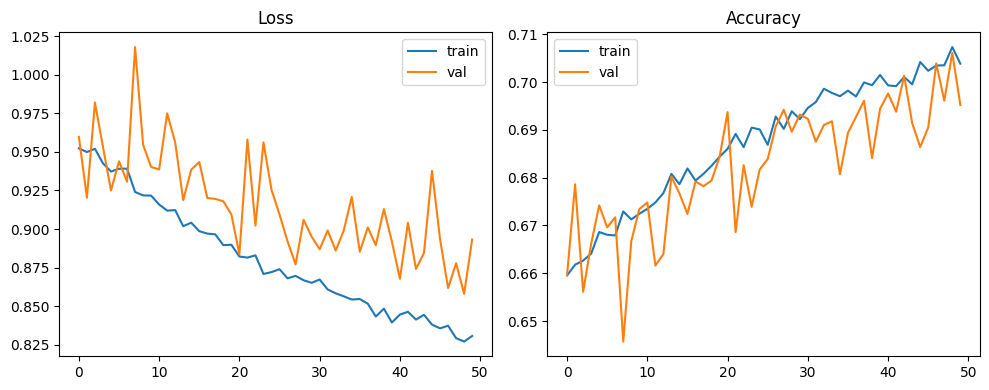

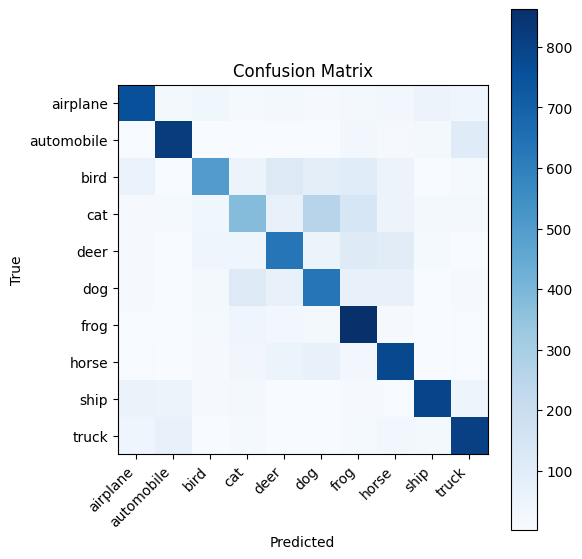

In [11]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")

# Plot learning curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrix
all_preds = []
all_labels = []
for batch_imgs, batch_labels in test_ds:
    preds = model.predict(batch_imgs, verbose=0)
    all_preds.append(np.argmax(preds, axis=1))
    all_labels.append(batch_labels.numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = tf.math.confusion_matrix(all_labels, all_preds, num_classes=10).numpy()

plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(10), class_names, rotation=45, ha="right")
plt.yticks(range(10), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

## 9. Key takeaways and next steps

- **Convolution layers** learn spatial features (edges -> textures -> parts -> objects).
- **Pooling** reduces spatial size and helps the model become more robust to small shifts.
- **Fully-connected layers** combine learned features to make the final decision.
- **Loss functions** measure how wrong predictions are; we minimize them.
- **Optimizers** decide how to update weights; Adam is a strong default.
- **Metrics** help you track progress, but the loss is what the model actually optimizes.

### Common improvements to try

- Try **max pooling** instead of average pooling and compare results.
- Add **dropout** in the dense layers to reduce overfitting.
- Use **SGD + momentum** for a classic training setup.
- Increase **epochs** and add a **learning-rate schedule**.
- Explore more modern architectures (VGG, ResNet, EfficientNet).

If you are new to ML, try adjusting one thing at a time and observe how the training curves change.
